## Семинар 2 "Распознавание рукописных цифр"

ФИО:

Сим Роман Дмитриевич

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [49]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from tqdm import tqdm
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

In [5]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

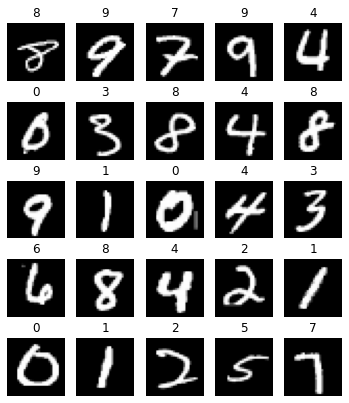

In [6]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [7]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [45]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 1.779/1.200	Accuracy: 0.371/0.697

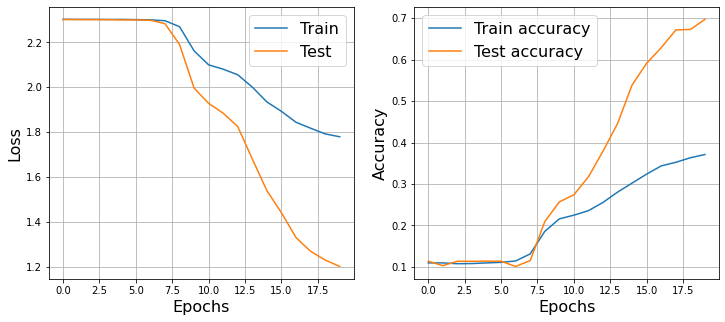

CPU times: user 15min 49s, sys: 11min 45s, total: 27min 35s
Wall time: 14min 12s


In [46]:
%time tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)
# CPU times: user 15min 49s, sys: 11min 45s, total: 27min 35s
# Wall time: 14min 12s

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [15]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [16]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''

    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 1.059/0.263	Accuracy: 0.639/0.948

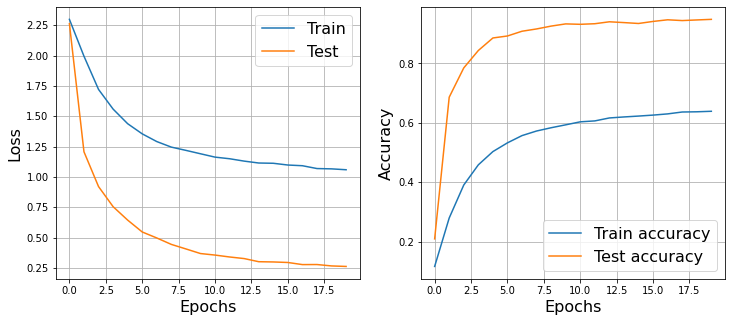

CPU times: user 15min 55s, sys: 11min 48s, total: 27min 44s
Wall time: 14min 31s


In [50]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
%time tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)
# CPU times: user 15min 55s, sys: 11min 48s, total: 27min 44s
# Wall time: 14min 31s

Epoch 19... (Train/Test) NLL: 1.056/0.255	Accuracy: 0.640/0.941

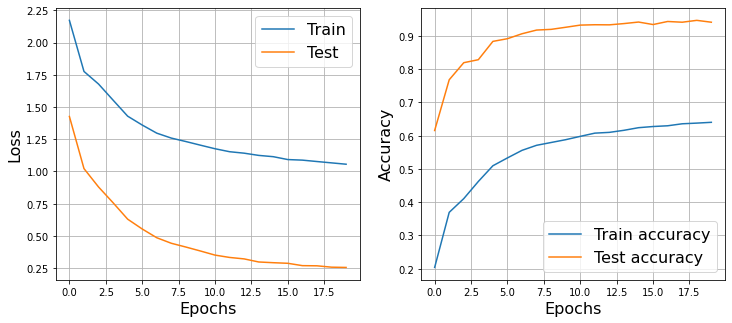

CPU times: user 16min 12s, sys: 12min 2s, total: 28min 15s
Wall time: 14min 37s


In [51]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
%time tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)
# CPU times: user 16min 12s, sys: 12min 2s, total: 28min 15s
# Wall time: 14min 37s

### Часть 3: Анализ ошибок
На каких объектах сеть ошибается больше всего?

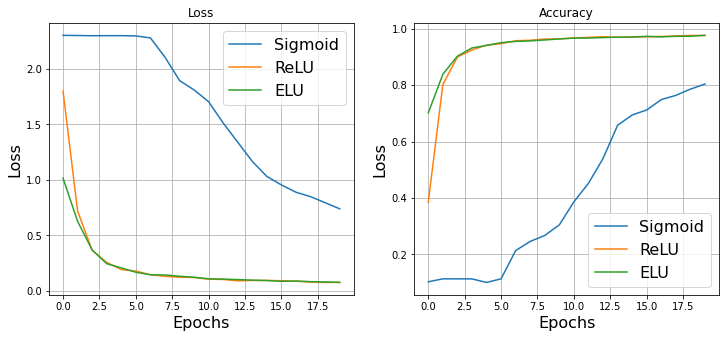

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

In [20]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

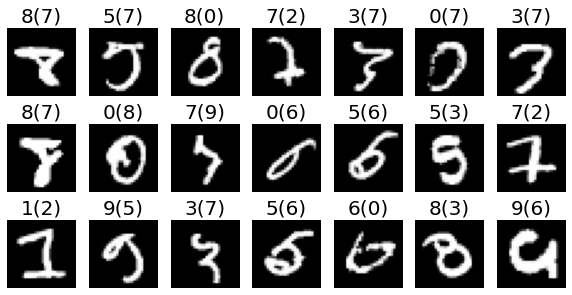

In [21]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### HW1 (1 балл): Реализовать Tanh

In [22]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return (2. / (1 + np.exp(-2 * X))) - 1.

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dydX = 4 / ((np.exp(self.X) + np.exp(-self.X)) ** 2)
        return dLdy * dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 1.311/0.409	Accuracy: 0.558/0.913

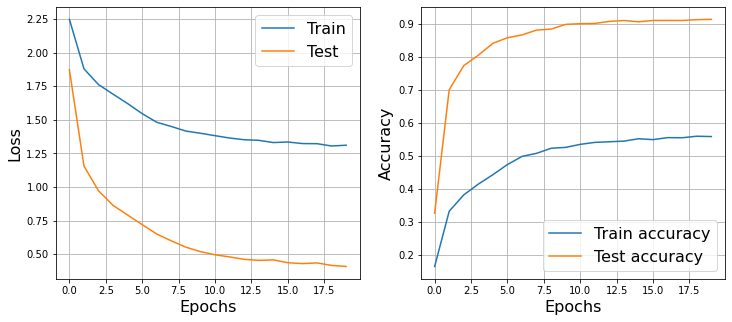

CPU times: user 16min 27s, sys: 12min 16s, total: 28min 43s
Wall time: 14min 48s


In [31]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
%time tr_th, ts_th, tr_ac_th, ts_ac_th = train(network, 20, 0.01)
# CPU times: user 16min 27s, sys: 12min 16s, total: 28min 43s
# Wall time: 14min 48s

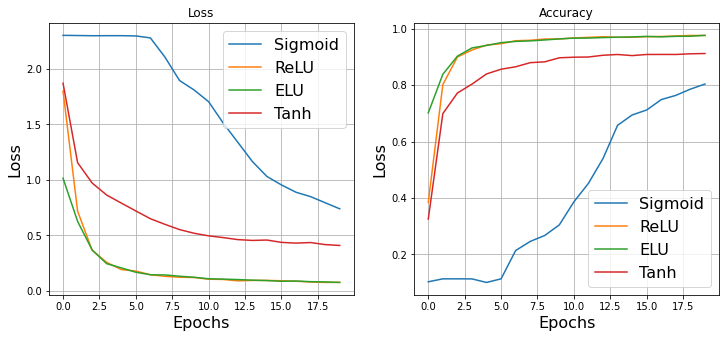

In [32]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_th, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_th, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [33]:
from skimage.transform import rotate

Epoch 19... (Train/Test) NLL: 0.072/0.069	Accuracy: 0.978/0.978

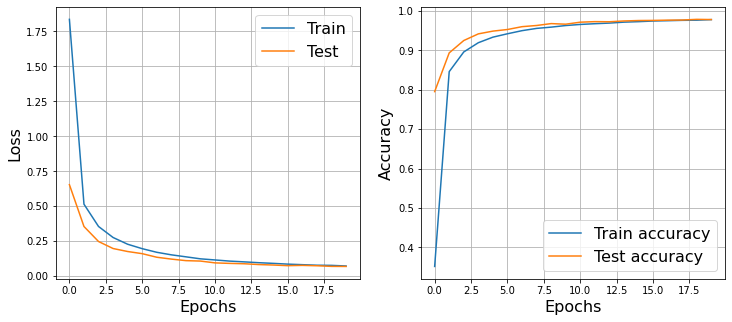

CPU times: user 11min 48s, sys: 8min 35s, total: 20min 24s
Wall time: 10min 32s


In [34]:
degrees = 15
transform_rotation = transforms.Compose([
    transforms.RandomRotation(degrees),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = MNIST('.', train=True, download=True, transform=transform_rotation)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])

%time tr_l_r, t_l_r, tr_a_r, t_a_r = train(network, 20, 0.01)
# CPU times: user 11min 48s, sys: 8min 35s, total: 20min 24s
# Wall time: 10min 32s

Epoch 19... (Train/Test) NLL: 0.160/0.084	Accuracy: 0.951/0.974

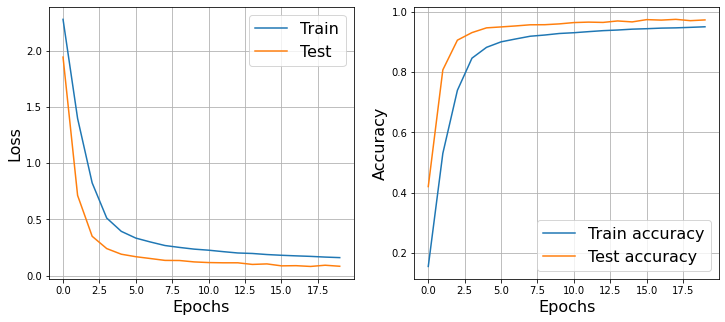

CPU times: user 12min 41s, sys: 9min 16s, total: 21min 58s
Wall time: 11min 23s


In [35]:
transform_a = transforms.Compose([
    transforms.RandomAffine(20, translate=(0.1,0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = MNIST('.', train=True, download=True, transform=transform_a)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])

%time tr_l_a, t_l_a, tr_a_a, t_a_a = train(network, 20, 0.01)
# CPU times: user 12min 41s, sys: 9min 16s, total: 21min 58s
# Wall time: 11min 23s

Epoch 19... (Train/Test) NLL: 0.504/0.152	Accuracy: 0.832/0.959

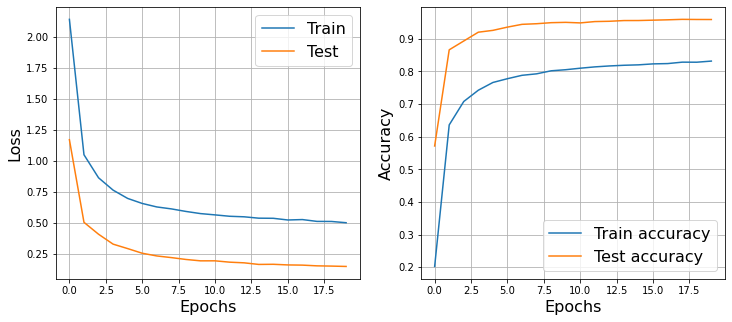

CPU times: user 9min 42s, sys: 6min 59s, total: 16min 41s
Wall time: 8min 42s


In [36]:
transform_l = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x : x + torch.randn_like(x)),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = MNIST('.', train=True, download=True, transform=transform_l)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])

%time tr_l_n, t_l_n, tr_a_n, t_a_n = train(network, 20, 0.01)
# CPU times: user 9min 42s, sys: 6min 59s, total: 16min 41s
# Wall time: 8min 42s

Epoch 19... (Train/Test) NLL: 1.071/0.268	Accuracy: 0.636/0.949

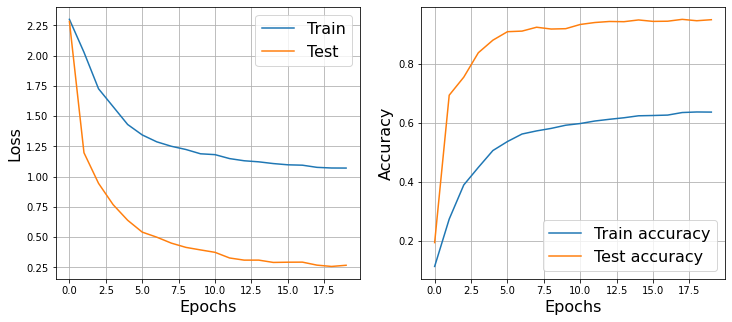

CPU times: user 15min 51s, sys: 11min 45s, total: 27min 36s
Wall time: 14min 14s


In [37]:
transform_all = transforms.Compose([
    transforms.RandomRotation(degrees),
    transforms.RandomAffine(20, (0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x : x + torch.randn_like(x)),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = MNIST('.', train=True, download=True, transform=transform_all)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])

%time tr_l_all, t_l_all, tr_a_all, t_a_all = train(network, 20, 0.01)
# CPU times: user 15min 51s, sys: 11min 45s, total: 27min 36s
# Wall time: 14min 14s

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

Epoch 19... (Train/Test) NLL: 1.051/0.247	Accuracy: 0.642/0.943

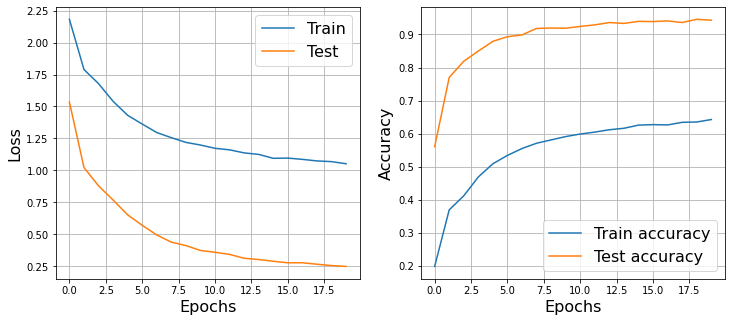

CPU times: user 16min 16s, sys: 12min 6s, total: 28min 23s
Wall time: 14min 43s


In [38]:
transform_all = transforms.Compose([
    transforms.RandomRotation(degrees),
    transforms.RandomAffine(20, (0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x : x + torch.randn_like(x)),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = MNIST('.', train=True, download=True, transform=transform_all)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

network = NeuralNetwork([
    Linear(784, 100), ELU(),
    Linear(100, 100), ELU(),
    Linear(100, 10)
])

%time tr_elu_all, t_elu_all, tr_elu_all, t_elu_all = train(network, 20, 0.01)
# CPU times: user 16min 16s, sys: 12min 6s, total: 28min 23s
# Wall time: 14min 43s

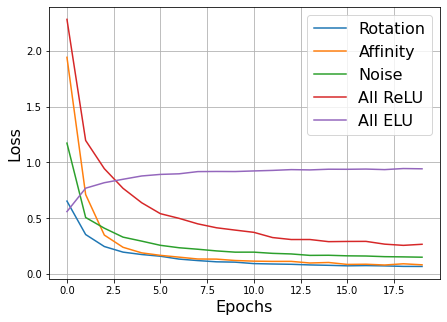

In [39]:
plt.figure(figsize=(7, 5))

plt.plot(t_l_r, label='Rotation')
plt.plot(t_l_a, label='Affinity')
plt.plot(t_l_n, label='Noise')
plt.plot(t_l_all, label='All ReLU')
plt.plot(t_elu_all, label='All ELU')

plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

- __Нелинейности:__  
Tanh быстрее сходится, ReLU и ELU показывают примерно одинаковую скорость сходимости, сигмоида медленнее всех.
По качеству Tanh, ReLU и ELU - показывают примерно одинаковый результат, сигмоида значительно хуже. 
- __Предобработка данных:__  
Случайные сдвиги и повороты улучшают качество модели, шум - ухудшает.